In [1]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="multitrialdb", password="coap")
  con.set_session(readonly=True, autocommit=False)
    

In [2]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*,
	COUNT(e.message_marker)
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
  JOIN event e ON e.observer_id = d.dnid
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

1client_0attackerstaggered_120secserver_2retry_reuse_90vs100conns_8000_microcloud


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system,count
0,1client_0attackerstaggered_120secserver_2retry...,3,3,1,originserver,pc2133,ubuntu1804-std,131626
1,1client_0attackerstaggered_120secserver_2retry...,3,4,4,proxy,microcloud,ubuntu1804-std,263252
2,1client_0attackerstaggered_120secserver_2retry...,3,2,5,client1,pc3060,ubuntu1804-std,130233


In [3]:
exp_id = "1client_0attackerstaggered_120secserver_2retry_reuse_90vs100conns_8000_microcloud"

node_map_node_id = dict()
node_map_dnid = dict()

df = lay_of_the_land
records = df[(df["exp_id"] == exp_id)][["node_name", "dnid", "node_id"]].to_records(index=False)
for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    
pprint(node_map_node_id)
pprint(node_map_dnid)

{'client1': 5, 'originserver': 1, 'proxy': 4}
{'client1': 2, 'originserver': 3, 'proxy': 4}


In [48]:
client_messages_sql = f"""
SELECT
    e.observe_timestamp,
    e.message_marker,
    e.trial,
	m.src_id,
	m.dst_id,
    m.size_bytes
FROM
	event e
	JOIN message m ON e.message_id = m.message_id
WHERE
	e.observer_id IN ({node_map_dnid['client1']})
ORDER BY
    e.observe_timestamp
;
"""

df = pd.read_sql_query(client_messages_sql, con)
con.commit()

# Negate timestamp of client src message to measure RTT
df["observe_timestamp"] = df.where(df["src_id"] != node_map_node_id['client1'], df["observe_timestamp"] * -1, axis=0)

rtts_df = df.groupby(by=["trial", "message_marker"]).agg(\
                                              rtt_sec=("observe_timestamp", "sum"), 
                                              timestamp=("observe_timestamp", "max"),
                                              min_size_bytes=("size_bytes", "min")).reset_index()
rtts_df = rtts_df[rtts_df["rtt_sec"] > 0]
rtts_df["rtt_ms"] = rtts_df["rtt_sec"] * 1e3


for t in rtts_df["trial"].unique():
    print(f"Trial {t}")
    trial_df = rtts_df[rtts_df["trial"] == t]
    trial_df["count"] = np.arange(1, len(trial_df) + 1)
    print(trial_df.describe())
    average_rps = trial_df["count"].max() / (trial_df["timestamp"].max() - trial_df["timestamp"].min())
    print(f"\naverage_rps={average_rps}")
    print()

rtts_df

Trial 1
         trial  message_marker       rtt_sec     timestamp  min_size_bytes  \
count  21532.0    21532.000000  21532.000000  2.153200e+04         21532.0   
mean       1.0    10766.500000      0.004129  1.636141e+09            78.0   
std        0.0     6215.897334      0.000696  2.735885e+01             0.0   
min        1.0        1.000000      0.003331  1.636140e+09            78.0   
25%        1.0     5383.750000      0.003980  1.636141e+09            78.0   
50%        1.0    10766.500000      0.004020  1.636141e+09            78.0   
75%        1.0    16149.250000      0.004228  1.636141e+09            78.0   
max        1.0    21532.000000      0.093419  1.636141e+09            78.0   

             rtt_ms         count  
count  21532.000000  21532.000000  
mean       4.128595  10766.500000  
std        0.696448   6215.897334  
min        3.330946      1.000000  
25%        3.980160   5383.750000  
50%        4.019737  10766.500000  
75%        4.228115  16149.250000  
m

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

,trial,message_marker,rtt_sec,timestamp,min_size_bytes,rtt_ms
0,1,1,0.093419,1.636140e+09,78,93.419075
1,1,2,0.006880,1.636140e+09,78,6.879807
2,1,3,0.006119,1.636140e+09,78,6.119013
3,1,4,0.006279,1.636140e+09,78,6.278753
4,1,5,0.006494,1.636140e+09,78,6.494045
...,...,...,...,...,...,...
65112,3,21741,0.003988,1.636141e+09,78,3.988266
65113,3,21742,0.003978,1.636141e+09,78,3.977776
65114,3,21743,0.003961,1.636141e+09,78,3.960848
65115,3,21744,0.003983,1.636141e+09,78,3.983021


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


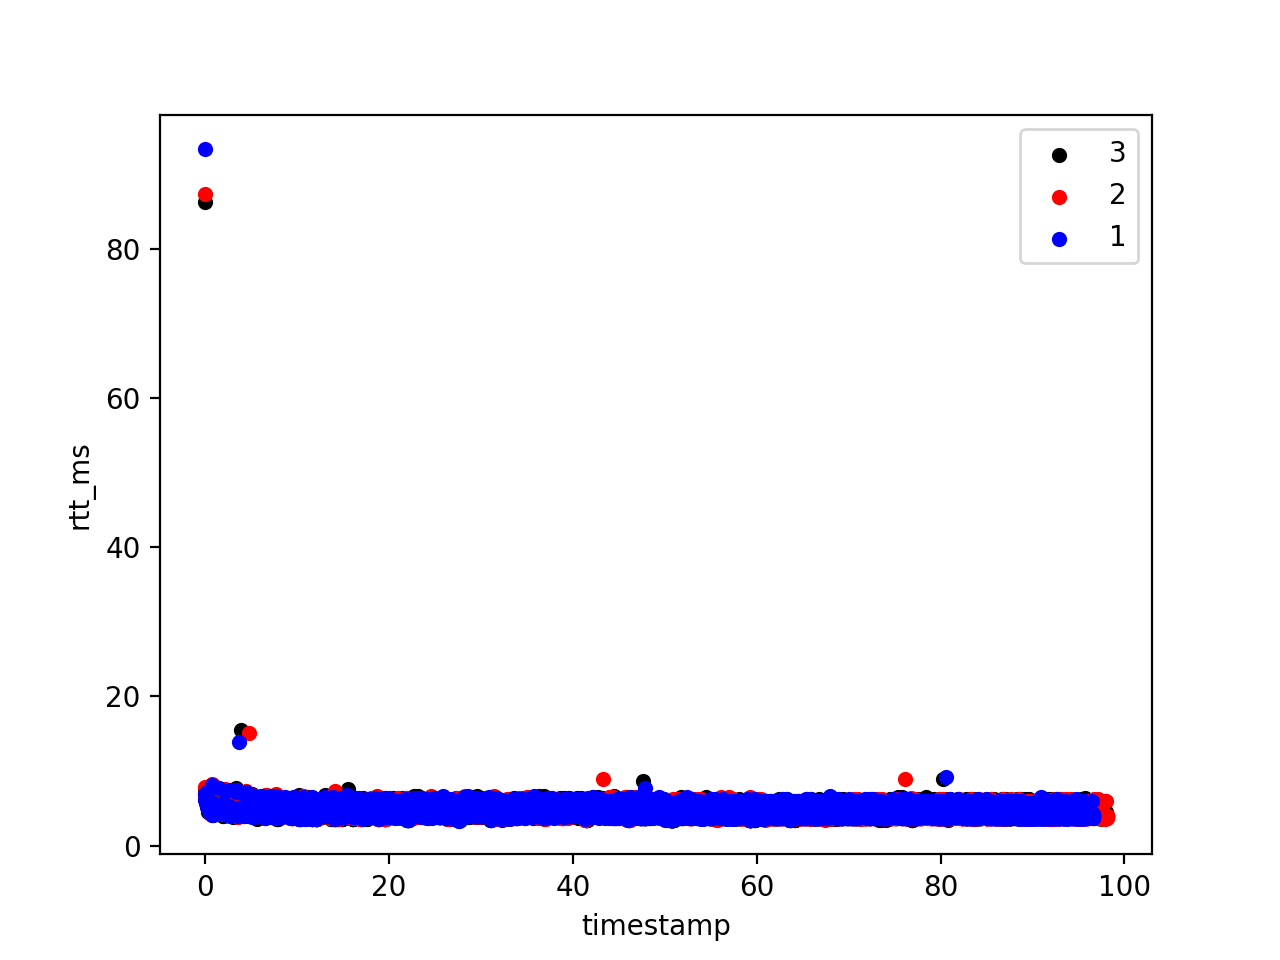

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
%matplotlib notebook

ax = None
color_map = {0: "orange", 1: "blue", 2: "red", 3: "black"}
for t in reversed(rtts_df["trial"].unique()):
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    ax = trial_df.plot(kind="scatter", x="timestamp", y="rtt_ms", label=t, ax=ax, color=color_map[t])
plt.show()

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


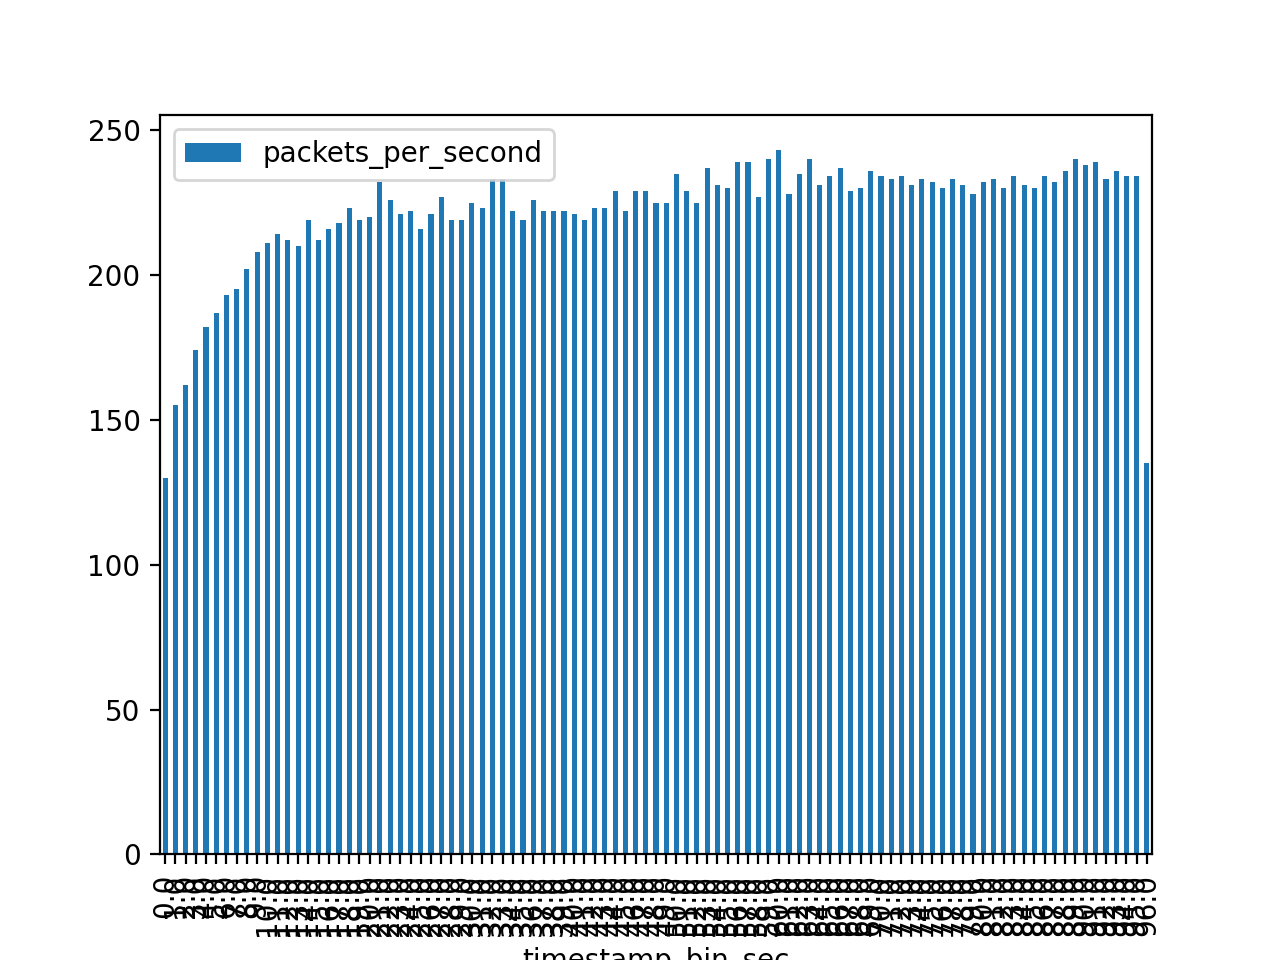

<IPython.core.display.Javascript object>


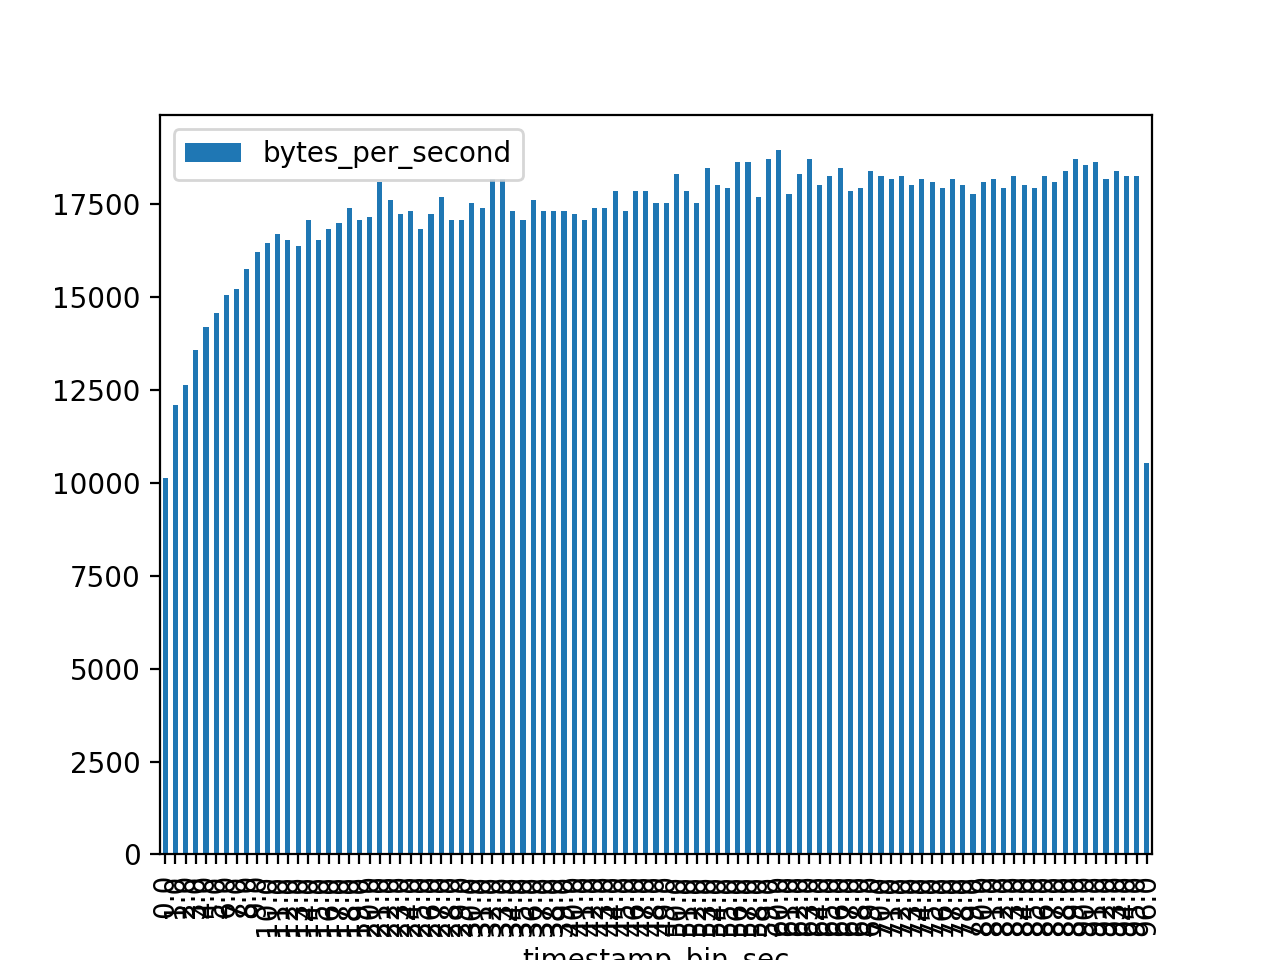

,timestamp_bin_sec,packets_per_second,bytes_per_second
0,0.0,130,10140
1,1.0,155,12090
2,2.0,162,12636
3,3.0,174,13572
4,4.0,182,14196
...,...,...,...
92,92.0,233,18174
93,93.0,236,18408
94,94.0,234,18252
95,95.0,234,18252


In [69]:
trial_df["timestamp_bin_sec"] = np.floor(trial_df["timestamp"])

time_stats_df = trial_df.groupby(by="timestamp_bin_sec").agg(\
                                         packets_per_second=("min_size_bytes", "count"),
                                         bytes_per_second=("min_size_bytes", "sum")).reset_index()

time_stats_df.plot(kind="bar", x="timestamp_bin_sec", y="packets_per_second")
time_stats_df.plot(kind="bar", x="timestamp_bin_sec", y="bytes_per_second")

time_stats_df

In [42]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
df = trial_df[(trial_df["rtt_ms"] > 6) & (trial_df["timestamp"] > 0.5)]
df["timestamp_diff"] = df.timestamp.diff()
df.describe()

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,trial,message_marker,rtt_sec,timestamp,rtt_ms,timestamp_diff
count,132.0,132.000000,132.000000,132.000000,132.000000,131.000000
mean,1.0,8187.719697,0.006466,38.531034,6.465572,0.717317
std,0.0,5834.979513,0.000778,25.845395,0.777965,0.692720
min,1.0,102.000000,0.006000,0.805011,6.000042,0.023733
25%,1.0,3106.750000,0.006215,16.183171,6.214678,0.449228
50%,1.0,7323.500000,0.006258,35.100948,6.258488,0.463972
75%,1.0,12045.250000,0.006469,56.002212,6.469131,0.656478
max,1.0,21110.000000,0.013858,94.773570,13.857841,5.601869
